# 06/23

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import pystan
import arviz

## Recap

Last time we wrote a sampler to estmiate the posterior distribution. In very simple cases we can directly compute the posterior probabilities. However, in high-dimensional cases where we have a lot of parameters, it is infeasible get the posterior distribution by solving a high-dimensional integral. At the same time, sampling algorithms still work fine, and we can get good estimates of the distrbuition.

## Stan

From now on we will be working in Stan. We just need to specify the function that returns values proportional to the posterior probabilities, and Stan will take care of everything else.

PyStan is the Python interface for Stan, which can be installed via `pip install stan`.

### Model 1
A simple example to show how Stan works. Stan wants data to be a dictionary of array-like objects.

In [2]:
df = pd.DataFrame([1.3, 4.5, 4.4, 5.5], columns = ['x'])
stan_data = {}
stan_data['NROWS'] = len(df.index)
stan_data['x'] = list(df['x'])
print(stan_data)

{'NROWS': 4, 'x': [1.3, 4.5, 4.4, 5.5]}


Below is the syntax for loading the model specified in a seperate .stan file, drawing samples, and showing the fit.

In [3]:
model = pystan.StanModel(file="model1.stan")
fit = model.sampling(data=stan_data, iter=1000, chains=2)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb8dbd48f1d2e5f9b53cff25d71923c8 NOW.


Inference for Stan model: anon_model_bb8dbd48f1d2e5f9b53cff25d71923c8.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
h      3.15    0.28    4.6  -5.57  -0.05   3.03   6.27  12.33    267    1.0
lp__  -0.64    0.03   0.76  -2.97  -0.79  -0.37  -0.17  -0.11    619    1.0

Samples were drawn using NUTS at Wed Jul  1 14:42:24 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


There are golden standards for what **Rhat** and **the number of effective samples** should be. The maximum Rhat for each parameter is 1.1. The standard of the number of effective samples is 5 * the number of split chains.

For PyStan trace plotting, we need `arviz` via `pip install arviz`.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1320f51d0>,
      dtype=object)

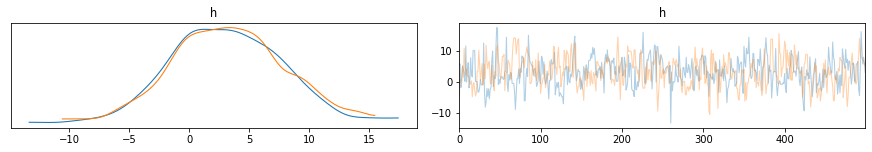

In [4]:
arviz.plot_trace(fit)

It's a good practice to check for divergence; i.e, you want your model to have no divergent transitions. 

In [1]:
# fit.get_sampler_params()
# There is a column called "divergent__".

You can make a histogram of the samples.

(array([  2.,   9.,  41., 118., 252., 247., 189., 100.,  34.,   8.]),
 array([-13.34411881, -10.26875463,  -7.19339045,  -4.11802627,
         -1.04266209,   2.0327021 ,   5.10806628,   8.18343046,
         11.25879464,  14.33415882,  17.40952301]),
 <a list of 10 Patch objects>)

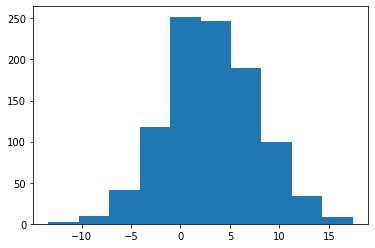

In [6]:
plt.hist(fit.extract('h')['h'])

### Model 2
We add a standard deviation parameter to our model. As we have seen, it is very straightforward to add parameters in Stan, but that would be pretty laborious if we write the "log posterior" function ourselves.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_48ca6f444164a4a4892f393040fdf6e9 NOW.


Inference for Stan model: anon_model_48ca6f444164a4a4892f393040fdf6e9.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
h      3.88    0.02   0.49   2.91   3.57   3.88   4.17   4.89    677    1.0
s      0.96  6.8e-3   0.17   0.68   0.85   0.95   1.07   1.33    605    1.0
lp__ -15.89    0.05   1.01 -18.67 -16.25 -15.58 -15.16 -14.91    369    1.0

Samples were drawn using NUTS at Wed Jul  1 14:43:02 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1321994d0>,
      dtype=object)

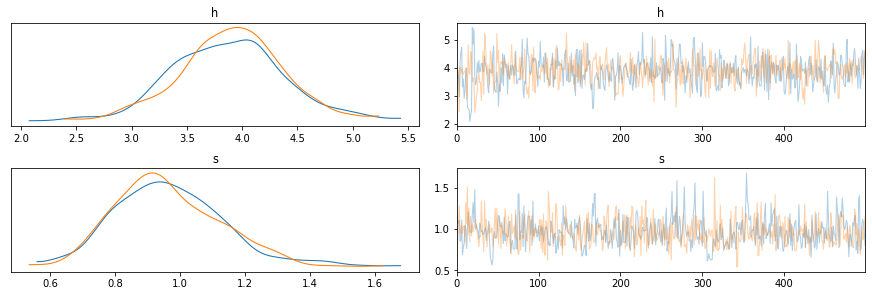

In [7]:
model = pystan.StanModel(file="model2.stan")
fit = model.sampling(data=stan_data, iter=1000, chains=2)
print(fit)
arviz.plot_trace(fit)

### Regression Model
Let's try a simple regression model. The important thing is to make sure that you understand **regression.stan**.

In [8]:
x = [1, 2, 3, 4]
y = [1.3, 4.5, 4.4, 5.5]
df = pd.DataFrame(np.array([x, y]).T, columns = ['x', 'y'])
stan_data = {}
stan_data['NROWS'] = len(df.index)
stan_data['x'] = list(df['x'])
stan_data['y'] = list(df['y'])
print(stan_data)

{'NROWS': 4, 'x': [1.0, 2.0, 3.0, 4.0], 'y': [1.3, 4.5, 4.4, 5.5]}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8298b91a292f4d0ad3788a443abeb37d NOW.


Inference for Stan model: anon_model_8298b91a292f4d0ad3788a443abeb37d.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b0     0.68    0.11   1.62  -2.68  -0.19   0.79   1.51   4.07    227    1.0
b1     1.27    0.04    0.6  -0.05   0.96   1.26   1.59   2.48    243    1.0
s      1.33    0.06   0.73   0.51   0.85   1.16    1.6   3.31    143   1.01
lp__  -4.14    0.17   2.05   -9.1  -5.15  -3.74  -2.58  -1.64    143    1.0

Samples were drawn using NUTS at Wed Jul  1 14:43:40 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1324ef850>,
      dtype=object)

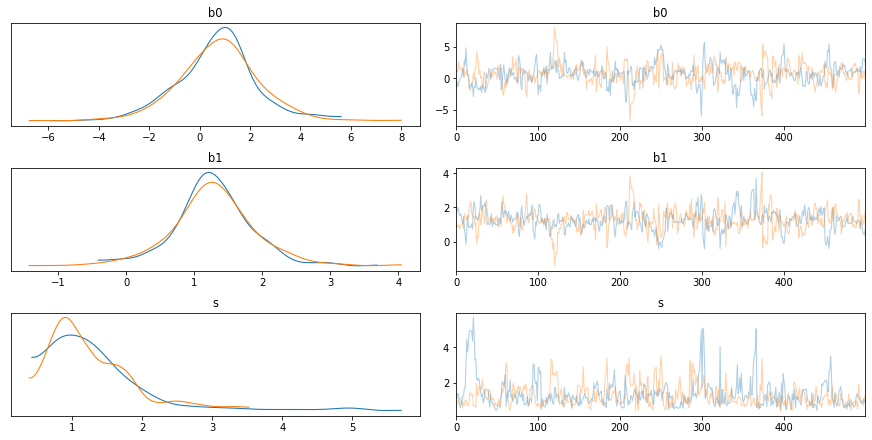

In [9]:
model = pystan.StanModel(file="regression.stan")
fit = model.sampling(data=stan_data, iter=1000, chains=2)
print(fit)
arviz.plot_trace(fit)